# FINM 33150 1 Regression Analysis and Quantitative Trading Strategies
### Shreyank Shetty (12279686)
# Simple Spread Trading

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
from matplotlib import cm
plt.rcParams["figure.figsize"] = (16,10)
import functools
import warnings
import statsmodels.api as sm
warnings.filterwarnings('ignore')

### Fethcing Data From Quandl

In [2]:
@functools.lru_cache(maxsize=16)
def fetch_quandl(table, tick,start,end):
    print("Fetching from Quandl")
    qdata = quandl.get_table(table,ticker=tick, date = { 'gte': start, 'lte': end },
                      api_key='Uqzcx--xVuNuaLvU48UU',
                      )
    return qdata
    print("fetch_quandl has now been newly defined")


In [3]:
ftsl = fetch_quandl(table='QUOTEMEDIA/PRICES',tick= 'FTSL', start='2019-12-02',end='2021-12-31')
smh= fetch_quandl(table='QUOTEMEDIA/PRICES',tick= 'SMH', start='2019-12-02',end='2021-12-31')

Fetching from Quandl
Fetching from Quandl


In [4]:
smh

,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume
None,,,,,,,,,,,,,,
0,SMH,2021-12-31,310.02,312.040,308.71,308.79,1463820.0,0.0,1.0,310.020000,312.040000,308.710000,308.790000,1463820.0
1,SMH,2021-12-30,313.06,314.010,309.27,309.83,2951857.0,0.0,1.0,313.060000,314.010000,309.270000,309.830000,2951857.0
2,SMH,2021-12-29,313.09,315.550,311.48,313.39,3112123.0,0.0,1.0,313.090000,315.550000,311.480000,313.390000,3112123.0
3,SMH,2021-12-28,317.83,317.920,311.89,313.44,2534187.0,0.0,1.0,317.830000,317.920000,311.890000,313.440000,2534187.0
4,SMH,2021-12-27,309.31,316.675,309.08,316.56,3207973.0,0.0,1.0,309.310000,316.675000,309.080000,316.560000,3207973.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,SMH,2019-12-06,133.33,134.280,133.33,133.99,3375766.0,0.0,1.0,129.754203,130.678724,129.754203,130.396502,3375766.0
522,SMH,2019-12-05,131.86,132.390,131.47,132.03,2438125.0,0.0,1.0,128.323627,128.839413,127.944086,128.489068,2438125.0
523,SMH,2019-12-04,131.00,131.720,130.87,131.24,3237730.0,0.0,1.0,127.486691,128.187381,127.360178,127.720255,3237730.0


### Fetching fama french data from Ken French's website 

In [5]:
#date_cols = ["date"]
fama_french= pd.read_csv('F-F_Research_Data_Factors_daily.csv')
fama_french.drop(fama_french.tail(1).index,inplace=True)
fama_french['date'] = pd.to_datetime(fama_french['date'])
fama_french.set_index('date', inplace=True)
fama_french=fama_french['2019-12-02':'2021-12-31']

In [6]:
fama_french

,Mkt-RF,SMB,HML,RF
date,,,,
2019-12-02,-0.87,-0.24,0.46,0.007
2019-12-03,-0.66,0.60,-0.83,0.007
2019-12-04,0.60,0.13,0.25,0.007
2019-12-05,0.13,-0.21,0.46,0.007
2019-12-06,0.91,0.24,0.39,0.007
...,...,...,...,...
2021-11-23,-0.03,-0.51,1.74,0.000
2021-11-24,0.30,0.02,-0.86,0.000
2021-11-26,-2.22,-1.23,-0.93,0.000


### data pre-processing 

In [7]:
ftsl=ftsl[['volume','adj_close','date']]
ftsl['dollarVol']= ftsl['volume']*ftsl['adj_close']
ftsl.set_index('date', inplace=True)
ftsl=ftsl[::-1]

smh=smh[['volume','adj_close','date']]
smh['dollarVol']= smh['volume']*smh['adj_close']
smh.set_index('date', inplace=True)
smh=smh[::-1]

### Function that runs the trading strategy 

In [64]:
# Stop Loss function 
def get_stop_loss(s1_adj_close, s2_adj_close, s):
    stop= s*(s1_adj_close + s2_adj_close) 
    return stop 


def trading_strat(ftsl,smh,m,g,lj,band,s,plot):
    """Creates the spread between assets over a window.
    Arguments
    ftsl: pd.DataFrame       containing first etf
    smh:  pd.DataFrame       containing second etf
    m: int                   accumulation window for spread
    g: float                 position entry parameter
    lj:float                 position exit parameter
    band: int                band for trading
    s: float                 stop loss parameter

    Constraint g > j > 0
    """
    ftsl['rollingMedian']= ftsl['dollarVol'].rolling(15).median()
    smh['rollingMedian']= smh['dollarVol'].rolling(15).median()

    #data processing 
    smh=smh.rename(columns={"volume": "smh_vol", "adj_close": "smh_adj_close",'dollarVol':'smh_dollarVol','rollingMedian':'smh_rollingMed'})
    ftsl=ftsl.rename(columns={"volume": "ftsl_vol", "adj_close": "ftsl_adj_close",'dollarVol':'ftsl_dollarVol','rollingMedian':'ftsl_rollingMed'})
    df= pd.concat([ftsl,smh],axis=1)

    # creating the nt column
    df['nt'] = np.where(df['ftsl_rollingMed'] < df['smh_rollingMed'], df['ftsl_rollingMed'], df['smh_rollingMed'])

    #calculating spread returns 
    df['ftsl_ret']=df['ftsl_adj_close'].pct_change(periods=m)
    df['smh_ret']=df['smh_adj_close'].pct_change(periods=m)
    df['spread']= df['smh_ret']-df['ftsl_ret']
    #df['spread']= df['ftsl_ret']-df['smh_ret']

    #extracting only required columns from the dataframe 
    req_df=df[['nt','spread','ftsl_adj_close','smh_adj_close']]
    #req_df=req_df.dropna()

    #plot the spread 
    if plot==True:
        graph= req_df[['spread']]
        graph['-j']=lj
        graph['-g']=lj-band
        graph['j']=g-band
        graph['g']=g
        graph.plot(figsize=(16,8),title='ETF Spread Difference')

    # Using the qunatines to get a approximate value to input g and j values 
    # lower= req_df['spread'].quantile(0.25)
    # higher= req_df['spread'].quantile(0.75)


    j= g-band
    neg_j=lj
    neg_g=lj-band
    req_df['signal']=0
    n= req_df.shape[0]


    # looping through the dataframe to generate signals 
    
    short_spread=False
    long_spread=False
    stop_loss=False
    stop= get_stop_loss(req_df['ftsl_adj_close'][0],req_df['smh_adj_close'][0],s)
    neg_stop=-stop
    req_df['stoploss']=stop
    for row in range(0,n):
        if row < n-1:
            if pd.DatetimeIndex(req_df.index.values)[row].month != pd.DatetimeIndex(req_df.index.values)[row+1].month:
                stop_loss=False
                if long_spread==True:
                    req_df['signal'][row] = -1
                    long_spread = False
                elif short_spread==True:
                    req_df['signal'][row] = 1
                    short_spread = False   
            else:
                if stop_loss==False:

                    if req_df['spread'][row]>g and short_spread==False:
                        req_df['signal'][row]= -1
                        stop = get_stop_loss(req_df['ftsl_adj_close'][row],req_df['smh_adj_close'][row],s)
                        req_df['stoploss'][row]=stop
                        short_spread=True

                    elif abs(req_df['smh_adj_close'][row]-req_df['ftsl_adj_close'][row])>stop and short_spread==True:
                        req_df['signal'][row]= 1
                        short_spread=False
                        stop_loss=True


                    elif req_df['spread'][row]<j and short_spread==True:
                            req_df['signal'][row]=1
                            short_spread=False

                    elif req_df['spread'][row]<neg_g and long_spread==False:
                        req_df['signal'][row]=1
                        long_spread=True 
                        neg_stop = get_stop_loss(req_df['ftsl_adj_close'][row],req_df['smh_adj_close'][row],s)
                        req_df['stoploss'][row]= -neg_stop

                    elif req_df['spread'][row]>neg_j and long_spread==True:
                            req_df['signal'][row]= -1
                            long_spread=False

                    elif abs(req_df['smh_adj_close'][row]-req_df['ftsl_adj_close'][row])<neg_stop and long_spread==True:
                        req_df['signal'][row]= -1
                        long_spread=False
                        stop_loss=True
        else:
            if long_spread==True:
                req_df['signal'][row]= -1
            elif short_spread==True:
                req_df['signal'][row] = 1


    #Plotting the signals
    if plot==True:    
        spread_data = req_df['spread']
        fig, ax = plt.subplots(figsize=(30,15))
        ax.plot(spread_data)
        ax.plot(req_df[req_df["signal"] == 1].index, req_df[req_df["signal"] == 1]['spread'],'^', markersize = 10, color='g', label='entry')
        ax.plot(req_df[req_df["signal"] == -1].index, req_df[req_df["signal"] == -1]['spread'],'v', markersize = 10, color='r', label='exit')
        ax.plot(graph)
        plt.show()


    # calculating the pnl from the signals 

    initial_capital =max(req_df['nt'].dropna())*2
    cash= initial_capital 
    req_df['pnl']=0
    req_df['position']=0
    req_df['holdings_value']=0
    req_df['cash']=cash
    pos_open=False
    for row in range(0,n):

        if pos_open==True:    
            present_price= req_df['smh_adj_close'][row]-req_df['ftsl_adj_close'][row]
            price_diff= present_price-trade_price 
            req_df['pnl'][row]= position * price_diff
            req_df['cash'][row]= cash
            
            req_df['position'][row] = position
            req_df['holdings_value'][row] = (-1)*position*present_price

            if req_df['signal'][row]!=0:
                req_df['cash'][row]= cash + (position * present_price)
                cash = req_df['cash'][row]
                pos_open=False

        else:
            if req_df['signal'][row]!=0:

                position= int((req_df['nt'].fillna(0)[row]/100))*req_df['signal'][row]
                trade_price= req_df['smh_adj_close'][row]-req_df['ftsl_adj_close'][row]
                #trade_price= req_df['ftsl_adj_close'][row]-req_df['smh_adj_close'][row]
                req_df['cash'][row]= cash - position*trade_price
                cash= req_df['cash'][row]
                req_df['position'][row] = position
                
                req_df['holdings_value'][row] = (-1)*req_df['position'][row]*trade_price
                pos_open=True

            
            req_df['pnl'][row]= 0
            req_df['cash'][row]= cash

    req_df.loc[:,'return']=(req_df.cash-initial_capital)/initial_capital
    req_df['log_ret']=np.log(req_df['return'])
    req_df['Portfolio_value'] = req_df['cash']+ req_df['holdings_value']
    req_df['Portfolio_ret'] = req_df['Portfolio_value'].pct_change()
    return req_df

### Visualizing the Spread and the trading strategy signals for entry and exit 

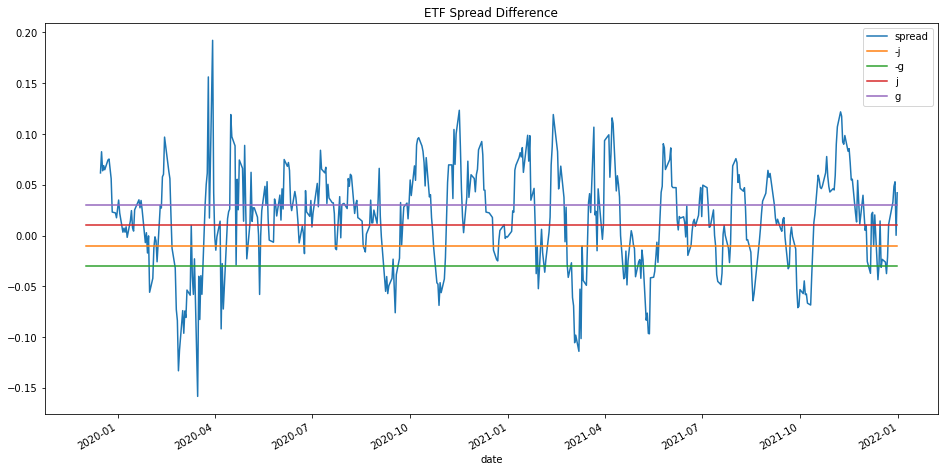

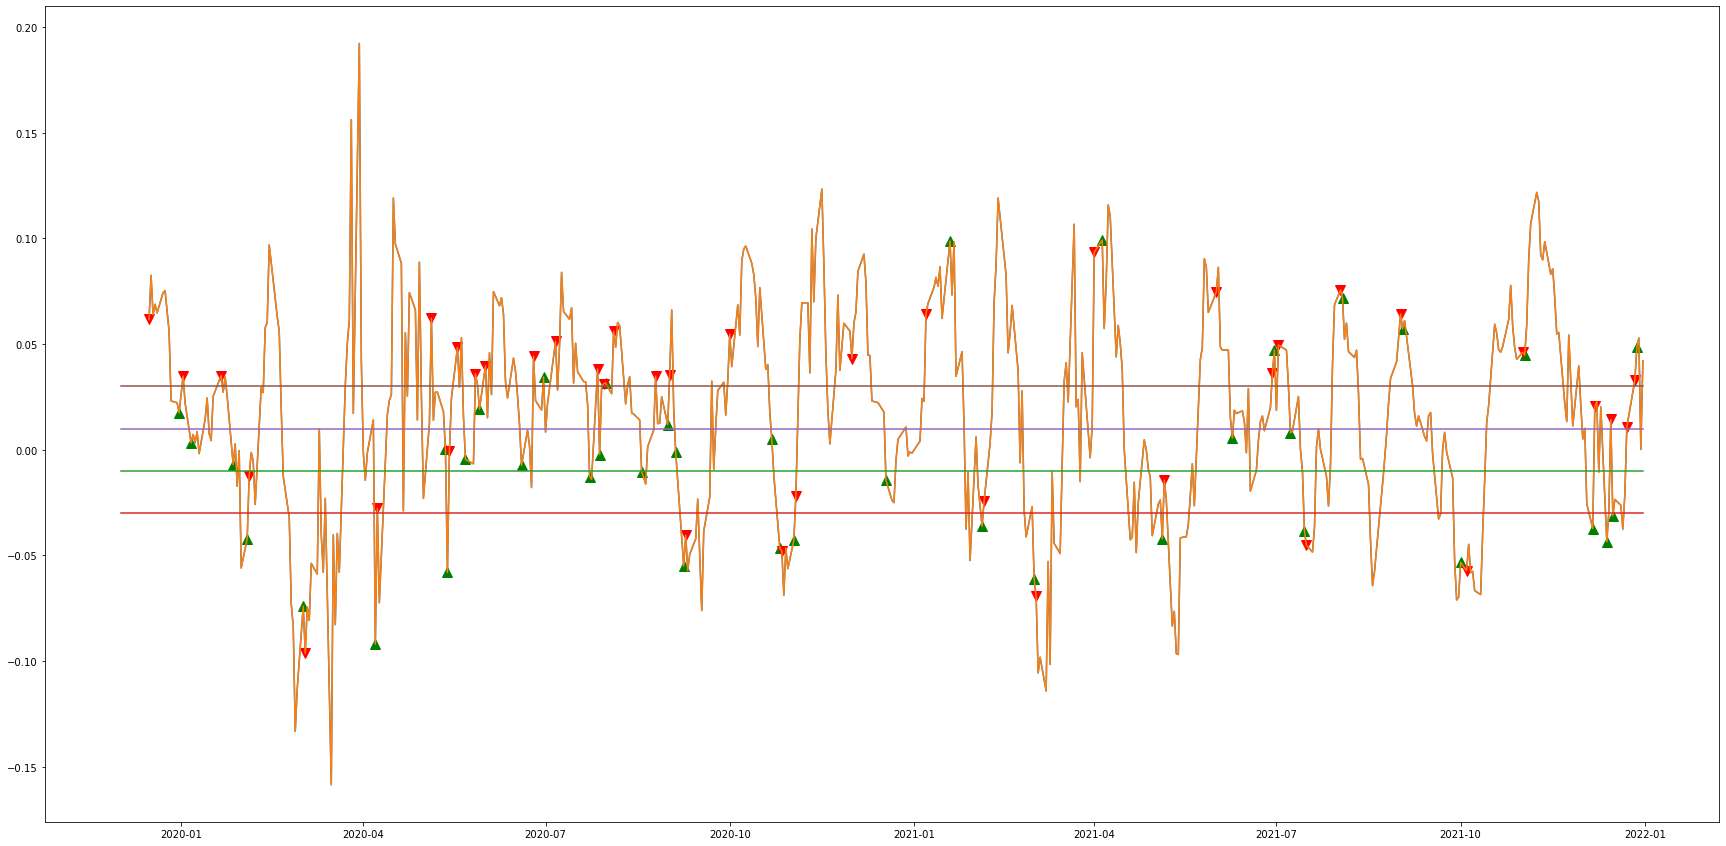

In [65]:
req_df= trading_strat(ftsl,smh,10,.03,-0.01,.02,0.7,True)

<AxesSubplot:xlabel='date'>

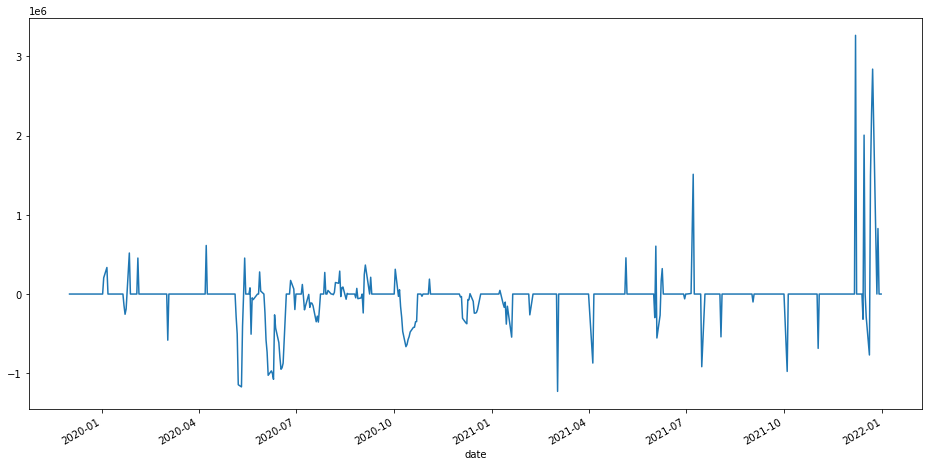

In [11]:
req_df.pnl.plot(figsize=(16,8))

<AxesSubplot:xlabel='date'>

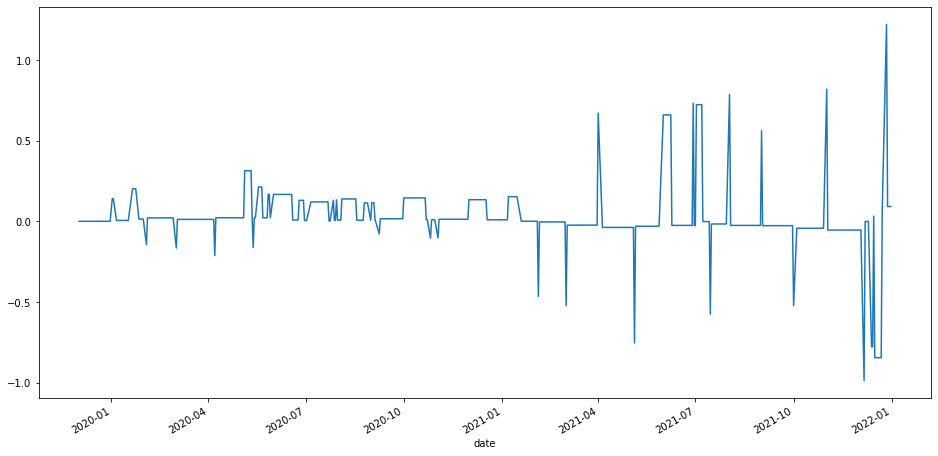

In [12]:
req_df['return'].plot(figsize=(16,8))

## Total return on capital from stratergy

In [13]:
req_df['cash'][-1]/req_df['cash'][0] -1

0.09143197346752463

We are gettting 9% return from the strategy 

In [14]:
req_df.to_csv('test.csv')

<AxesSubplot:xlabel='date'>

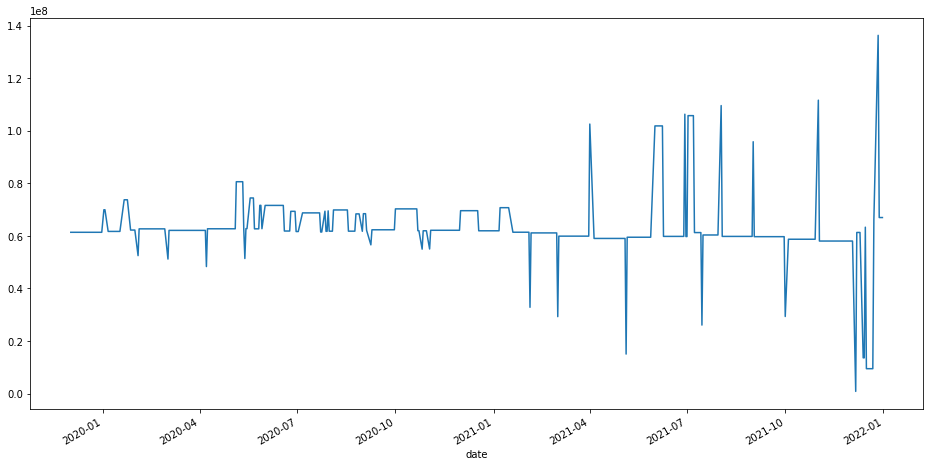

In [15]:
req_df.cash.plot(figsize=(16,8))

### Parameter Tuning

### Tuning M

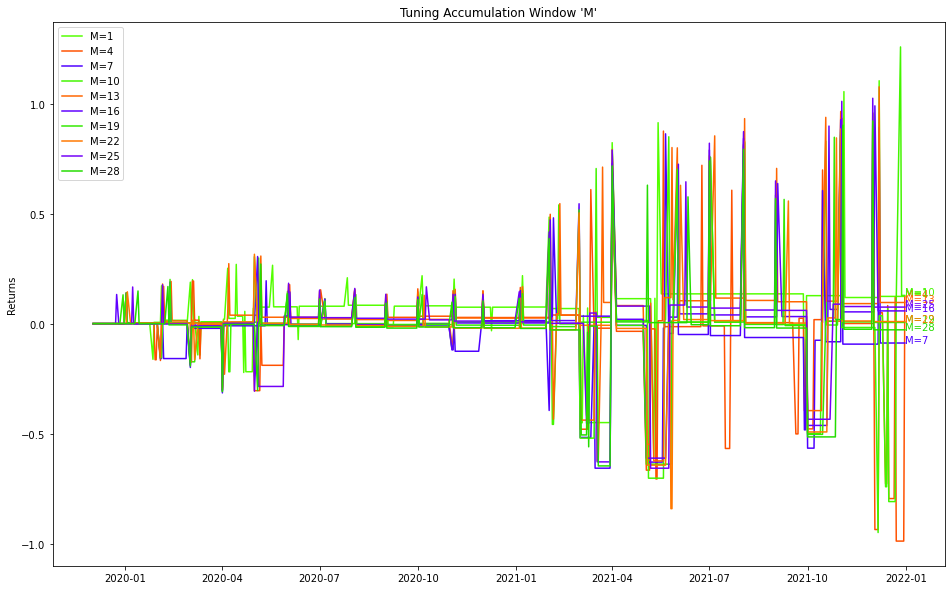

In [54]:
g = 0.03   # Entry parameter
j = -0.01 # Exit parameter
s = 0.5    # Stop Loss parameter
band= 0.02  #traidng band .048,-0.012,.05,0.05,
# M = 10      # Accumulation window to determine spread divergence
fig, ax = plt.subplots()

minim = 1
maxim = 31
Ms = range(minim,maxim,3)

for i, M in enumerate(Ms):
    strat = trading_strat(ftsl, smh,M, g, j, band,s,False)
    plot_ser = strat["return"]
    colo = cm.prism(255-i*8)
    ax.plot(plot_ser, c=colo, label=f"M={M}")
    ax.annotate(f"M={M}", xy=(plot_ser.index[-1], plot_ser.iloc[-1]), c=colo)
    ax.set_ylabel("Returns")

plt.title("Tuning Accumulation Window 'M'")
plt.legend()
plt.show()

### Tuning parameter g 

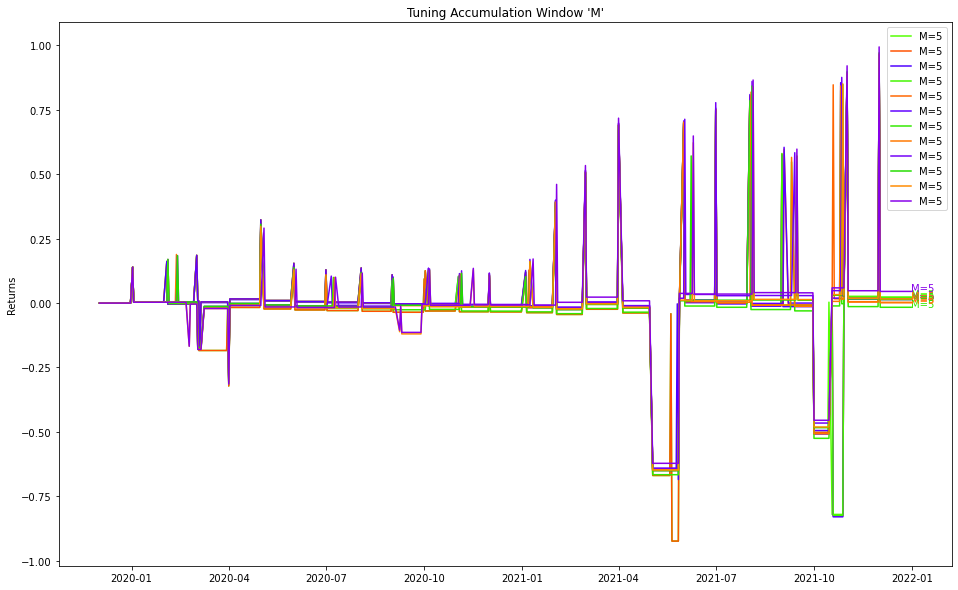

In [63]:
#g = 0.03# Entry parameter
import numpy
j = -0.01 # Exit parameter
s = 0.5    # Stop Loss parameter
band= 0.02  #traidng band .048,-0.012,.05,0.05,
M = 5      # Accumulation window to determine spread divergence
fig, ax = plt.subplots()

minim = -0.04
maxim = 0.08
G = numpy.arange(minim,maxim,0.01)

for i, g in enumerate(G):
    strat = trading_strat(ftsl, smh,m, g, j, band,s,False)
    plot_ser = strat["return"]
    colo = cm.prism(255-i*8)
    ax.plot(plot_ser, c=colo, label=f"M={M}")
    ax.annotate(f"M={M}", xy=(plot_ser.index[-1], plot_ser.iloc[-1]), c=colo)
    ax.set_ylabel("Returns")

plt.title("Tuning Accumulation Window 'M'")
plt.legend()
plt.show()

In [ ]:
g = 0.03   # Entry parameter
j = -0.01 # Exit parameter
s = 0.5    # Stop Loss parameter
band= 0.02  #traidng band .048,-0.012,.05,0.05,
# M = 10      # Accumulation window to determine spread divergence
fig, ax = plt.subplots()

minim = 1
maxim = 31
Ms = range(minim,maxim,3)

for i, M in enumerate(Ms):
    strat = trading_strat(ftsl, smh,M, g, j, band,s,False)
    plot_ser = strat["return"]
    colo = cm.prism(255-i*8)
    ax.plot(plot_ser, c=colo, label=f"M={M}")
    ax.annotate(f"M={M}", xy=(plot_ser.index[-1], plot_ser.iloc[-1]), c=colo)
    ax.set_ylabel("Returns")

plt.title("Tuning Accumulation Window 'M'")
plt.legend()
plt.show()

### Running Simulation to figure out the best parameter values 

In [28]:
simulation_frame = pd.DataFrame()

M_periods =[5,10,15,20]
g_array =[.03, .04, 0.05, .06, .07, .08]
j_array =[-0.01, 0.0, .01, .02,-0.02]
s_array =[0.45, 0.25, 0.50, 0.75]


for m in M_periods:
    for g in g_array:
        for j in j_array:
            for s in s_array:
                data_in_hand = trading_strat(ftsl,smh,m,g,j,.02,s,False)
                simulation_at_hand = "M_" + str(m) + "j_" + str(j) + "g_" + str(g) + "s_" + str(s)
                simulation_frame[simulation_at_hand] = data_in_hand['Portfolio_value']

In [29]:
simulation_frame.iloc[-1,:].idxmax()

'M_5j_0.0g_0.03s_0.45'

<AxesSubplot:xlabel='date'>

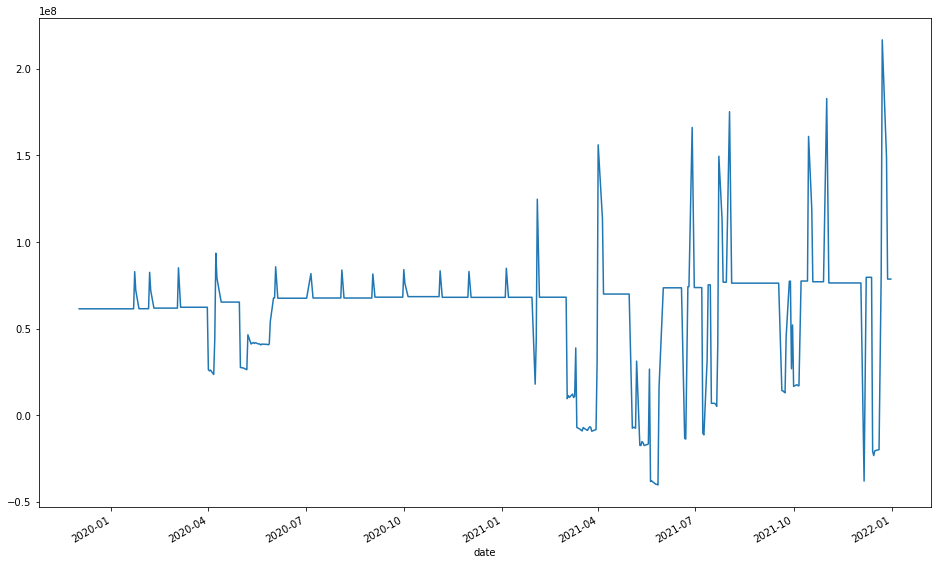

In [35]:
simulation_frame[simulation_frame.iloc[-1,:].idxmax()].plot()

In [37]:
optimal_strat_df= trading_strat(ftsl,smh,5,0.03,0.0,.02,.45,False)

In [39]:
optimal_strat_df['cash'][-1]/optimal_strat_df['cash'][0] -1

0.2796844587624827

### Regressing strategy returns with the fama-french model 

In [52]:
optimal_strat_df['Portfolio_ret'] = optimal_strat_df['Portfolio_value'].pct_change(periods=1).dropna()

fama_french["myportfolio"]= optimal_strat_df['Portfolio_ret']

fama_french = fama_french.dropna()

Y = fama_french["myportfolio"]
X = sm.add_constant(fama_french[["Mkt-RF","SMB","HML","RF"]])

In [51]:
reg_results = sm.OLS(Y,X).fit()
reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            myportfolio   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.2481
Date:                Thu, 27 Jan 2022   Prob (F-statistic):              0.911
Time:                        22:24:24   Log-Likelihood:                -511.38
No. Observations:                 503   AIC:                             1033.
Df Residuals:                     498   BIC:                             1054.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.033      0.045      0.964      -0.063       0.066
Mkt-RF         0.0168      0.019      0.896      0.371      -0.020       0.054
SMB           -0.0162      0.036     -0.447      0.655      -0.087       0.055
HML            0.0036      0.023      0.158      0.874      -0.041       0.048
RF             0.6283     13.030      0.048      0.962     -24.972      26.228
==============================================================================
Omnibus:                      267.418   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40314.275
Skew:                           1.223   Prob(JB):                         0.00
Kurtosis:                      46.790   Cond. No.                         746.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our strategy has a low r squared with the fama-french model. Hence the strategy offers diversification from the market.  

In [ ]:
#Conclusion 

- The strategy enters at the fringe bands of the spreads
- The more 
